In [ ]:
import numpy as np
import struct
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal, ndimage

import torch
from torch import nn
from torch.utils.data import Dataset
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

0.0 1.0
0.0 1.0


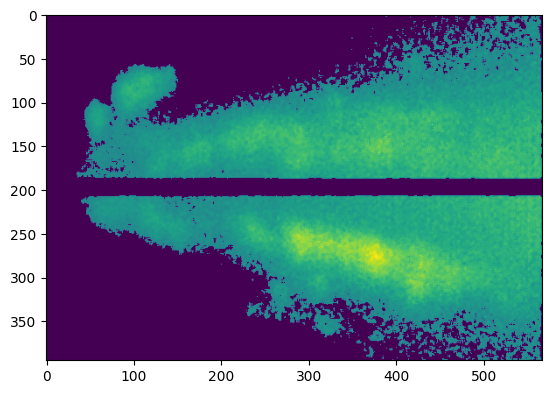

[[0.         0.         0.         ... 0.56610315 0.51236972 0.        ]
 [0.         0.         0.         ... 0.56610315 0.4745677  0.        ]
 [0.         0.         0.         ... 0.4804192  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.47458295 0.46903563 0.        ]
 [0.         0.         0.         ... 0.48072842 0.47458295 0.        ]
 [0.         0.         0.         ... 0.47433984 0.47433984 0.        ]]


In [ ]:
#file = open('rags04ah.RCP-514-USB.arc2.bin', 'rb')
file = open('raks02aa.514.lcp-rcp.averaged.secspec.1133x395.bin', 'rb')

#file = open('secspec_slice_512x201.bin', 'rb')
bin = bytearray(file.read())
binlist = list(struct.unpack('f'*int(len(bin)/4), bin))

x_size = 1133
y_size = 395
eps = 10

data = np.array(binlist, dtype=np.float32).reshape(y_size, x_size)
data = np.log10(data)

data = data[:, int(x_size/2):]
data[(int(y_size/2)-eps):(int(y_size/2)+eps), :] = data.min()

gauss = np.array([[0.000789, 0.006581, 0.013347, 0.006581, 0.000789],
                [0.006581, 0.054901, 0.111345, 0.054901, 0.006581],
                [0.013347, 0.111345, 0.225821, 0.111345, 0.013347],
                [0.006581, 0.054901, 0.111345, 0.054901, 0.006581],
                [0.000789, 0.006581, 0.013347, 0.006581, 0.000789]])
filter1 = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])

Gx = np.array([[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]])
Gy = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])
data_x = signal.convolve2d(data, Gx, mode='same')
data_y = signal.convolve2d(data, Gy, mode='same')


data += abs(data.min())
data /= abs(data.max())
print(data.min(), data.max())

for i in range(y_size):
  for j in range(int(x_size/2)):
    data[i,j] *= np.sqrt(j)

data = data/data.max()


threshold = 0.4
data = np.array([[item if (item > threshold) else 0 for item in row] for row in data])
data = ndimage.median_filter(data, size=4)

#data = signal.convolve2d(data, gauss, mode='same')

data = data/data.max()
#data = np.sqrt(data_x*data_x + data_y*data_y)

print(data.min(), data.max())


plt.imshow(data)
plt.show()
print(data)

In [ ]:
'''
threshold = 0.5
datalist = np.array([[int(item > threshold) for item in row] for row in data])
plt.imshow(datalist)
plt.show()
'''

'\nthreshold = 0.5\ndatalist = np.array([[int(item > threshold) for item in row] for row in data])\nplt.imshow(datalist)\nplt.show()\n'

In [ ]:
datalist = np.array([[i, j, data[i,j]] for i in range(sizex) for j in range(sizey) if data[i, j] > 0])

In [ ]:
print(datalist.shape)
X = np.array([[item] for item in datalist[:, 0]])
Y = np.array([[item] for item in datalist[:, 1]])
W = np.array([item for item in datalist[:, 2]])
#np.argwhere(np.isnan(datalist))

(41718, 3)


Text(0, 0.5, 'целевая переменная')

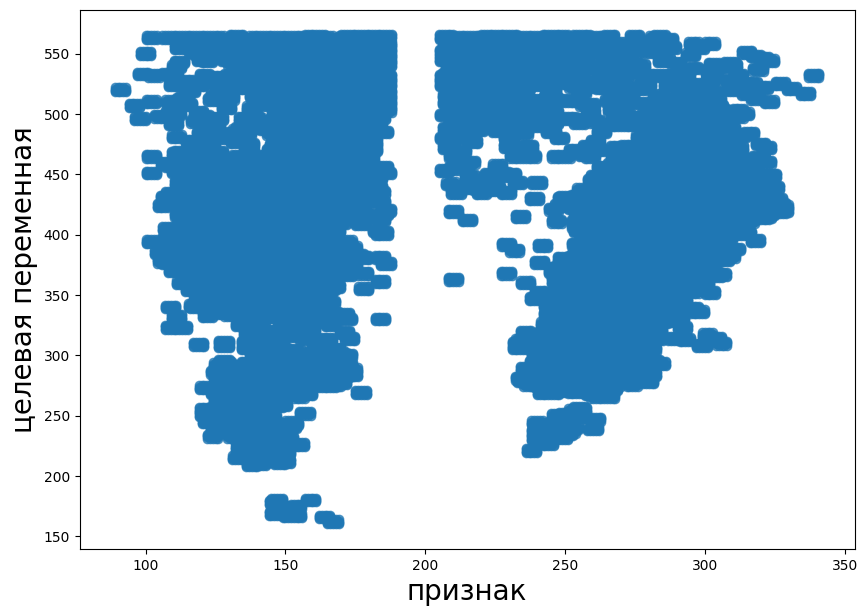

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X, Y, alpha=0.7)
plt.xlabel('признак', fontsize = 20)
plt.ylabel('целевая переменная', fontsize = 20)

In [ ]:
import statsmodels.api as sm
X2 = [x**2 for x in X]
d = {'X': X, 'X^2': X2}
X1 = pd.DataFrame(data = d)
X1 = sm.add_constant(X1)
model = sm.OLS(Y, X1)
results = model.fit()
print(results.summary())

ValueError: Per-column arrays must each be 1-dimensional

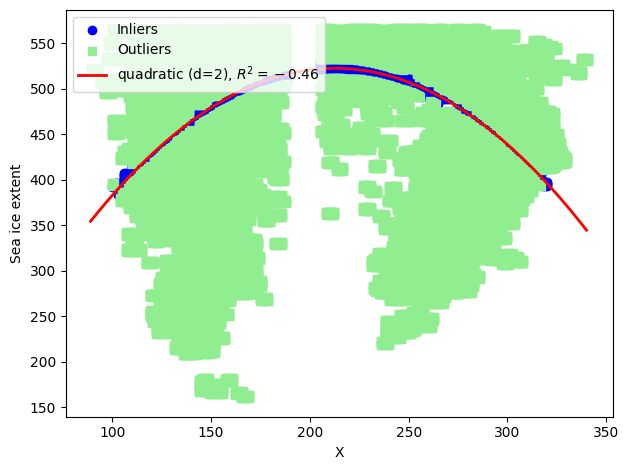

[[-9.93256225e-30  4.66793107e+00 -1.09704590e-02]]


In [ ]:
# Define RANSAC regressor
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=10,
    residual_threshold=10,
    random_state=0,
)

# Fit RANSAC model to data
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
ransac = ransac.fit(X_quad, Y, sample_weight=W)

# Get fitted RANSAC curve
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
y_quad_fit = ransac.predict(quadratic.fit_transform(X_fit))

# Get R2 value
quadratic_r2 = r2_score(Y, ransac.predict(X_quad))

# Plot inliers
inlier_mask = ransac.inlier_mask_
plt.scatter(X[inlier_mask], Y[inlier_mask], c="blue", marker="o", label="Inliers")

# Plot outliers
outlier_mask = np.logical_not(inlier_mask)
plt.scatter(
    X[outlier_mask], Y[outlier_mask], c="lightgreen", marker="s", label="Outliers"
)

# Plot fitted RANSAC curve
plt.plot(
    X_fit,
    y_quad_fit,
    label="quadratic (d=2), $R^2=%.2f$" % quadratic_r2,
    color="red",
    lw=2,
    linestyle="-",
)

plt.xlabel("X")
plt.ylabel("Sea ice extent")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

coeff = ransac.estimator_.coef_
print(coeff)

Text(0, 0.5, 'целевая переменная')

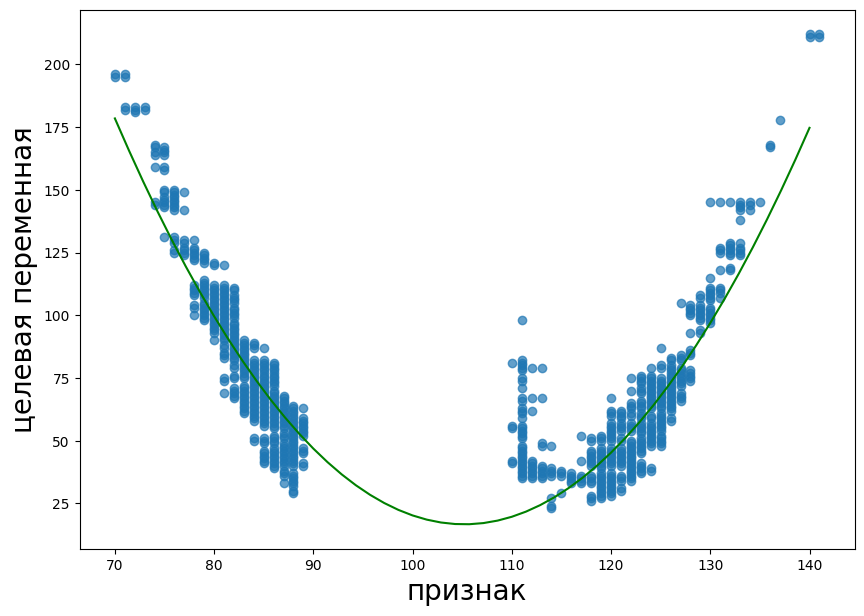

In [ ]:




plt.figure(figsize=(10,7))
plt.scatter(X, Y, alpha=0.7)
t = np.linspace(70, 140)
plt.plot(t, -27.4586*t + 0.1305*t*t+1461.0963, 'g')
plt.xlabel('признак', fontsize = 20)
plt.ylabel('целевая переменная', fontsize = 20)

In [ ]:
a = torch.zeros(1, requires_grad=True)
x0 = torch.zeros(1, requires_grad=True)
c = torch.zeros(1, requires_grad=True)

x = torch.FloatTensor(X)
y = torch.FloatTensor(Y)
# Количество эпох
num_epochs = 100

# Скорость обучения для весов
lr_a = 0.001
lr_x0 = 0.1
lr_c = 0.1

for i in range(num_epochs):
    # Forward pass: предсказание модели
    y_pred = a*torch.square(x-x0) + c

    # Подсчет функции потерь
    loss = torch.mean(int(abs(y_pred - y) < 10.0))

    # Backward pass: подсчет градиентов
    loss.backward()
    print()
    # Оптимизация: обновение весов
    a.data -= lr_a * a.grad.data
    x0.data -= lr_x0 * x0.grad.data
    c.data -= lr_c * c.grad.data

    # Зануление градиентов
    a.grad.data.zero_()
    x0.grad.data.zero_()
    c.grad.data.zero_()


    # График + вывод лосса
    if True:
        clear_output(True)
        plt.figure(figsize=(10,7))
        plt.scatter(x.data.numpy(), y.data.numpy(), alpha=0.75)
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color='orange', linewidth=5)
        plt.xlabel('признак')
        plt.ylabel('целевая переменная')
        plt.show()

        print("loss = ", loss.data.numpy())

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
X.shape

(100, 1)

In [ ]:

# Get example sea-ice data
df = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/seaice.csv"
)
df["index1"] = df.index

# Define X and y
start=2950
X = (df[["index1"]].values)[start:start+100]
y = (df[["Extent"]].values)[start:start+100]

# Define RANSAC regressor
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=50,
    residual_threshold=0.15,
    random_state=0,
)

# Fit RANSAC model to data
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
ransac = ransac.fit(X_quad, y)

# Get fitted RANSAC curve
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
y_quad_fit = ransac.predict(quadratic.fit_transform(X_fit))

# Get R2 value
quadratic_r2 = r2_score(y, ransac.predict(X_quad))

# Plot inliers
inlier_mask = ransac.inlier_mask_
plt.scatter(X[inlier_mask], y[inlier_mask], c="blue", marker="o", label="Inliers")

# Plot outliers
outlier_mask = np.logical_not(inlier_mask)
plt.scatter(
    X[outlier_mask], y[outlier_mask], c="lightgreen", marker="s", label="Outliers"
)

# Plot fitted RANSAC curve
plt.plot(
    X_fit,
    y_quad_fit,
    label="quadratic (d=2), $R^2=%.2f$" % quadratic_r2,
    color="red",
    lw=2,
    linestyle="-",
)

plt.xlabel("X")
plt.ylabel("Sea ice extent")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()